In [1]:
# from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import sys, random
from transformers import (
    BertTokenizer,
    BertConfig,
    EarlyStoppingCallback,
    RobertaTokenizer,
    RobertaConfig,
    Trainer,
    TrainingArguments,
)
from collections import OrderedDict
import pandas as pd
# from transformers.adapters import AdapterArguments,setup_adapter_training
from datasets import load_from_disk, Dataset
from typing import Dict, List, Optional
# from icecream import ic

## path to text contrastive learning library
PATH_TO_COTRALIB = 'textContraLib'
PATH_TO_SENTEVAL = 'SentEval/'
PATH_TO_DATA = 'SentEval/data'

sys.path.insert(0, PATH_TO_COTRALIB)
sys.path.insert(0, PATH_TO_SENTEVAL)
import senteval
from models import (
    SimCSEModel,
    PromptModel,
    VisualGuidedPromptModel,
    VisualGuidedPromptModel_roberta,
)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from tools import print_table, print_full_table, print_trainable_parameters, evalTransferModel

In [2]:
model_name = 'bert-base-uncased'

# visual_ft_path = 'data/flickr30k/flickr30k_trainset_img_features_768x768_p32.pt'

# visual_ft_path = 'data/COCO2017/COCO2017_trainset_img_features_1024x1024_p14.pt'
# visual_ft_path = 'data/COCO2017/COCO2017_trainset_img_features_768x768_p32.pt'
# visual_ft_path = 'data/flickr30k/flickr30k_trainset_img_features_768x768_p16.pt'
visual_ft_path = 'data/flickr30k/flickr30k_trainset_img_features_512_clip-vit-base-patch32.pt'
# visual_ft_path = 'data/flickr30k/flickr30k_trainset_img_features_512x512_p16.pt'
# visual_ft_path = 'data/COCO2017/COCO2017_trainset_img_features_clip-vit-base-patch32.pt'
# text_ft_path = 'data/COCO2017/COCO2017_trainset_text_features_clip-vit-base-patch32.pt'

# For test5/6#
# pretrained_vit_path = 'saved_clip_model/clip-vit-base-p32-finetuned_proj_768x768/pytorch_model.bin'

tokenizer = BertTokenizer.from_pretrained(model_name, cache_dir='./cache')

date = '8_15'

output_path = 'RESULTS\\FINAL\\bert-base_flickr_img_768to512_p32_mlp1_test2'

# output_path = 'RESULTS\\bert_large_coco_1024_test2'
# output_path = 'RESULTS\\bert_base_coco_768_test2'
# output_path = 'RESULTS\\bert_base_coco_768_test2'

template_idx = 23

In [3]:
# # Roberta
# model_name = 'roberta-base'

# visual_ft_path = 'data/flickr30k/flickr30k_trainset_img_features_512_clip-vit-base-patch32.pt'
# # visual_ft_path = 'data/COCO2017/COCO2017_trainset_img_features_clip-vit-base-patch32.pt'
# # visual_ft_path = 'data/COCO2017/COCO2017_trainset_img_features_768x768_p32.pt'
# # visual_ft_path = 'data/COCO2017/COCO2017_trainset_img_features_1024x1024_p14.pt'

# # pretrained_vit_path = 'saved_clip_model/clip-vit-base-p32-finetuned_proj_768x768/pytorch_model.bin'

# tokenizer = RobertaTokenizer.from_pretrained(model_name, cache_dir='./cache')
# date = '7_8'

# output_path = 'RESULTS\\roberta_base_flickr_768_test2'
# # output_path = 'RESULTS/roberta-base_coco_512_p32_test2'
# # output_path = 'RESULTS/roberta-large_coco_512_clip-vit-base-patch32_test2'

# template_idx = 25

In [4]:
def add_prompt(s, idx=0):
    prompt = {
        0: "This sentence : \"[ [S] ]\" means [MASK] !",
        1: "This sentence : \"[[S]]\" means <mask> !",     # roberta
        2: "\"[[S]]\" is [MASK] !",                        # X is [MASK].
        3:"\"[[S]]\" means [MASK] !",                      # X means [MASK].
        4: "\"[[S]]\" represents [MASK] !",                # X represents [MASK].
        5: "\"[[S]]\" stands for [MASK] !",                # # X stands for [MASK].
        6: "Text : \"[[S]]\" means [MASK] !",              # Text X means [MASK].
        7: "Sentence : \"[[S]]\" means [MASK] !",          # Sentence X means [MASK].
        8: "Statement : \"[[S]]\" means [MASK] !",         # Statement X means [MASK].
        9: "The statement : \"[[S]]\" means [MASK] !",     # The statement X means [MASK].
        10: "The sentence : \"[[S]]\" means [MASK] !",     # The sentence X means [MASK].
        11: "This statement : \"[[S]]\" means [MASK] !",   # This statement X means [MASK].
        12: "This sentence : \"[[S]]\" means [MASK] !",    # This sentence X means [MASK].
        13: "This sentence : \" [S] \" means [MASK] !",    # BERT
        14: "This sentence of \" [S] \" means [MASK] !",   # BERT
        15: "This sentence \"[S]\" means [MASK] !",           # This sentence "X" means [MASK].
        16: "This sentence : \" [S] \" means [MASK] !",    # This sentence : "X" means [MASK].
        17: "This sentence [ [S] ] means [MASK] !",        # This sentence [X] means [MASK].
        18: "This sentence ( [S] ) means [MASK] !",        # This sentence (X) means [MASK].
        19: "This sentence { [S] } means [MASK] !",        # This sentence {X} means [MASK].
        20: "This sentence \"{ [S] }\" means [MASK] !",    # This sentence "{X}" means [MASK].
        21: "This sentence : \"{ [S] }\" means [MASK] !",  # This sentence : "{X}" means [MASK].
        # Test ending punctuation mark
        22: "This sentence : \" [S] \" means [MASK] !",  # BERT
        23: "This sentence of \" [S] \" means [MASK] !",   # BERT
        24: "This sentence : \' [S] \' means <mask> !",    # Roberta
        25: "The sentence : \' [S] \' means <mask> !",     # Roberta
    }
    return prompt[idx].replace('[S]', s)

In [5]:
# process wiki-text for train
# use pandas to read simCSE-wiki.txt
# download from https://huggingface.co/datasets/princeton-nlp/datasets-for-simcse/resolve/main/wiki1m_for_simcse.txt
wiki_text_file = 'data/wiki1m_for_simcse.txt'
wiki = pd.read_csv(wiki_text_file, sep = '\t', header = None)
wiki.columns = ['text']
# use Dataset.from_pandas to convert to dataset
wiki_dataset = Dataset.from_pandas(wiki, split= "train") # type: ignore


un_remove_set = {'?', '*', '#', '´', '’', '=', '…', '|', '~', '/', '‚', '¿', '–', '»', '-', '€', '‘', '"', '(', '•', '`', '$', ':', '[', '”', '%', '£', '<', '[UNK]', ';', '“', '@', '_', '{', '^', ',', '.', '!', '™', '&', ']', '>', '\\', "'", ')', '+', '—'}
if model_name == 'roberta-base':
    remove_set = {'Ġ.', 'Ġa', 'Ġthe', 'Ġin', 'a', 'Ġ, ', 'Ġis', 'Ġto', 'Ġof', 'Ġand', 'Ġon', 'Ġ\'', 's', '.', 'the', 'Ġman', '-', 'Ġwith', 'Ġfor', 'Ġat', 'Ġwoman', 'Ġare', 'Ġ"', 'Ġthat', 'Ġit', 'Ġdog', 'Ġsaid', 'Ġplaying', 'Ġwas', 'Ġas', 'Ġfrom', 'Ġ:', 'Ġyou', 'Ġan', 'i', 'Ġby'}
else:
    remove_set = {".", "a", "the", "in", ",", "is", "to", "of", "and", "'", "on", "man", "-", "s", "with", "for", "\"", "at", "##s", "woman", "are", "it", "two", "that", "you", "dog", "said", "playing", "i", "an", "as", "was", "from", ":", "by", "white"}


def prepare_features(examples):
    
    total = len(examples['text'])
    # total = batch_size
    
    # Avoid "None" fields 
    for idx in range(total):
        if examples['text'][idx] is None:
            examples['text'][idx] = " "

    # add prompt
    sentences = [add_prompt(s, idx=template_idx) for s in examples['text']]

    # set max_length here:
    sent_features = tokenizer(sentences, max_length=77, truncation=True, padding="max_length")

    return sent_features

train_dataset = wiki_dataset.map(prepare_features, batched=True, remove_columns=['text'])  # TIME Consuming, about 9 mins for bert, 4.5 mins for roberta

#### [Recommended] just load the pre-processed file ###
# wiki_for_sts = "data/wiki_promptRobertabase_t2_64_with_mask"
# wiki_for_sts = "data/wiki_promptBertbase_t2_64_with_mask/"
# train_dataset = load_from_disk(wiki_for_sts)

Map:   0%|          | 0/995447 [00:00<?, ? examples/s]

In [6]:
res = []
import re
# promptBert专用EvalModel方法
def evalModel_withMask(model,tokenizer, pooler = "cls_before_pooler"):

    tasks = ['STS12', 'STS13', 'STS14', 'STS15', 'STS16', 'STSBenchmark', 'SICKRelatedness']
    
    # params = {'task_path': PATH_TO_DATA, 'usepytorch': True, 'kfold': 5}
    # params['classifier'] = {'nhid': 0, 'optim': 'rmsprop', 'batch_size': 128,
    #                             'tenacity': 3, 'epoch_size': 2}
    params = {'task_path': PATH_TO_DATA, 'usepytorch': True, 'kfold': 10}
    params['classifier'] = {'nhid': 0, 'optim': 'adam', 'batch_size': 64,
                                 'tenacity': 5, 'epoch_size': 4}

    def prepare(params, samples):
        return

    def batcher(params, batch, max_length=None):
        global SE
        # Handle rare token encoding issues in the dataset
        if len(batch) >= 1 and len(batch[0]) >= 1 and isinstance(batch[0][0], bytes):
            batch = [[word.decode('utf-8') for word in s] for s in batch]

        ### 加入prompt
        sentences = [add_prompt(' '.join(s).replace('\n', ' ').replace('  ', ' ').strip().lower(), idx=template_idx) for s in batch]

        batch = tokenizer.batch_encode_plus(
            sentences,
            return_tensors='pt',
            padding=True,
            max_length=max_length,
            truncation=True
        )

        # Move to the correct device
        for k in batch:
            batch[k] = batch[k].to(device)

        # Get raw embeddings
        with torch.no_grad():
            ### 用promptBert模型get mask embeddings
            output,mask_embs = model(**batch, output_hidden_states=True, return_dict=True,sent_emb=True)


        mask_embs = mask_embs.cpu()
        return mask_embs
        
    results = {}
    
    for task in tasks:
        se = senteval.engine.SE(params, batcher, prepare)
        result = se.eval(task)
        results[task] = result
    # res.append(results)
    task_names = []
    scores = []
    aligns = []
    uniforms = []
    
    for task in tasks:
        task_names.append(task)
        if task in results:
            if task in ['STS12', 'STS13', 'STS14', 'STS15', 'STS16']:
                scores.append("%.2f" % (results[task]['all']['spearman']['all'] * 100))
                aligns.append("%.3f" % (results[task]['all']['align_loss']['all']))
                uniforms.append("%.3f" % (results[task]['all']['uniform_loss']['all']))
            else:
                scores.append("%.2f" % (results[task]['test']['spearman'].correlation * 100))  # for STSB and SICK.
                aligns.append("%.3f" % (results[task]['test']['align_loss']))
                uniforms.append("%.3f" % (results[task]['test']['uniform_loss']))
        else:
            scores.append("0.00")
    task_names.append("Avg.")
    scores.append("%.2f" % (sum([float(score) for score in scores]) / len(scores)))
    aligns.append("%.3f" % (sum([float(score) for score in aligns]) / len(aligns)))
    uniforms.append("%.3f" % (sum([float(score) for score in uniforms]) / len(uniforms)))
    ret = {'avg_score': sum([float(score) for score in scores])/len(scores), 'scores':scores, 'aligns': aligns, 'uniforms': uniforms}
    print_full_table(task_names, scores, aligns, uniforms)
    
    return ret

In [7]:
corrs = []
class ProSimCSETrainer(Trainer):
    def __init__(self,**paraments):
        super().__init__(**paraments)
        
        self.best_sts = 0.0
        self.best_pool_sts = 0.0
        self.flag = False

    def evaluate(
        self,
        eval_dataset: Optional[Dataset] = None,
        ignore_keys: Optional[List[str]] = None,
        metric_key_prefix: str = "eval",
        eval_senteval_transfer: bool = False,
    ) -> Dict[str, float]:
        global corrs
        
        # Set params for SentEval (fastmode)
        params = {'task_path': PATH_TO_DATA, 'usepytorch': True, 'kfold': 5}
        params['classifier'] = {'nhid': 0, 'optim': 'rmsprop', 'batch_size': 128,
                                            'tenacity': 3, 'epoch_size': 2}

        self.model.eval()
        all_results = evalModel_withMask(self.model,tokenizer, pooler = 'cls_before_pooler')
        corrs.append(all_results['avg_score'])
        if all_results['avg_score'] > self.best_sts:
            self.best_sts = all_results['avg_score']
            self.save_model(self.args.output_dir+"\\best-model")
            if self.flag: # 判断是不是第一次记录数据
                # 如果是第一次，则记录，否则，更新最后一行数据
                lines_avg = open(self.args.output_dir+'\\avg_score_'+date+'.txt', 'r').readlines()
                # now edit the last line of the list of lines
                lines_avg[-1] = str(all_results['avg_score'])+'\n'
                # now write the modified list back out to the file
                open(self.args.output_dir+'\\avg_score_'+date+'.txt', 'w+').writelines(lines_avg)
                lines_scores = open(self.args.output_dir+'\\scores_'+date+'.txt', 'r').readlines()
                lines_scores[-1] = str(all_results['scores'])+'\n'
                open(self.args.output_dir+'\\scores_'+date+'.txt', 'w+').writelines(lines_scores)
                lines_aligns = open(self.args.output_dir+'\\aligns_'+date+'.txt', 'r').readlines()
                lines_aligns[-1] = str(all_results['aligns'])+'\n'
                open(self.args.output_dir+'\\aligns_'+date+'.txt', 'w+').writelines(lines_aligns)
                lines_uniforms = open(self.args.output_dir+'\\uniforms_'+date+'.txt', 'r').readlines()
                lines_uniforms[-1] = str(all_results['uniforms'])+'\n'
                open(self.args.output_dir+'\\uniforms_'+date+'.txt', 'w+').writelines(lines_uniforms)
            else:
                with open(self.args.output_dir+'\\avg_score_'+date+'.txt','a+') as f:
                    f.writelines(str(all_results['avg_score'])+'\n')
                with open(self.args.output_dir+'\\scores_'+date+'.txt','a+') as f:
                    f.writelines(str(all_results['scores'])+'\n')
                with open(self.args.output_dir+'\\aligns_'+date+'.txt','a+') as f:
                    f.writelines(str(all_results['aligns'])+'\n')
                with open(self.args.output_dir+'\\uniforms_'+date+'.txt','a+') as f:
                    f.writelines(str(all_results['uniforms'])+'\n')

            self.flag = True

        self.model.train()
        print('Spearman before pooler:',all_results['avg_score'],'\nmax spearman ',self.best_sts)
        self.log({'Spearman before pooler:':all_results['avg_score']})

        return {'eval_acc':all_results['avg_score']}

In [8]:
# config = BertConfig.from_pretrained(model_name, cache_dir='./cache')

# config = RobertaConfig.from_pretrained(model_name, cache_dir='./cache')

# ### PromptModel
# model = PromptModel(config)
# model.bert_model = model.bert_model.from_pretrained('bert-base-uncased', cache_dir='./cache')

### For loading original bert model parameters
# pretrain_bert = BertModel(config).from_pretrained('bert-base-uncased', cache_dir='./cache')
# pretrain_bert_dict = pretrain_bert.state_dict()
# embedding_dict = OrderedDict()
# encoder_dict = OrderedDict()
# pooler_dict = OrderedDict()
# for k, v in pretrain_bert_dict.items():
#     if 'embeddings' in k:
#         embedding_dict[k[11:]] = v
#     if 'encoder' in k:
#         encoder_dict[k[8:]] = v
#     if 'pooler' in k:
#         pooler_dict[k[13:]] = v

### DirectBYOLSEModel
# config.update({'decay':0.95, 'cut_dim':100})
# model = DirectBYOLSEModel(config)
# # online init
# model.online_embedding.load_state_dict(embedding_dict)
# model.online_encoder.load_state_dict(encoder_dict)
# # target init
# model.prepare()
# non_optimizer_list = [model.target_embedding,model.target_encoder]
# for layer in non_optimizer_list:
#     for para in layer.parameters():
#         para.requires_grad = False

### SimCSE
# model = SimCSEModel(config)
# model.embedding.load_state_dict(embedding_dict)
# model.encoder.load_state_dict(encoder_dict)
# model.projector.dense.load_state_dict(pooler_dict)


### PromptModel_Adapter
# model = PromptModel_Adapter(config)
# model.bert_model = model.bert_model.from_pretrained('bert-base-uncased', cache_dir='./cache')
# # Setup adapters
# adapter_args = AdapterArguments(
#     train_adapter = True,
# )
# setup_adapter_training(model.bert_model, adapter_args, 'adapter')
# model = model.cuda()

### add Lora
# config = LoraConfig(
#     r=4, #attention heads， 更新矩阵的秩
#     lora_alpha=16, #alpha scaling
#     # target_modules=["q_proj", "v_proj"], #if you know the 
#     lora_dropout=0.01,
#     bias="none",
#     task_type="SEQ_CLS",
#     inference_mode=False,
# )
# model = get_peft_model(model, config)

### VisualGuidedPromptModel
visual_pool = torch.load(visual_ft_path).cuda()

##########
# N,C = visual_pool1.shape
# index = torch.LongTensor(random.sample(range(N), round(N/2))).cuda()
# visual_pool1 = visual_pool1[index]
# visual_pool2 = torch.load(visual_ft_path2).cuda()
# N,C = visual_pool2.shape
# index = torch.LongTensor(random.sample(range(N), round(N/2))).cuda()
# visual_pool2 = visual_pool2[index]
# visual_pool = torch.vstack((visual_pool1, visual_pool2)).cuda()
##########

# text_pool =  torch.load(text_ft_path).cuda()
############### BERT ############################
config = BertConfig.from_pretrained(model_name, cache_dir='./cache')
model = VisualGuidedPromptModel(config=config, visual_pool=visual_pool, text_pool=None)
model.bert_model = model.bert_model.from_pretrained(model_name, cache_dir='./cache')
model.temp_denosie = False
############### Roberta ############################
# config = RobertaConfig.from_pretrained(model_name, cache_dir='./cache')
# model = VisualGuidedPromptModel_roberta(config=config, visual_pool=visual_pool)
# model.roberta_model = model.roberta_model.from_pretrained(model_name, cache_dir='./cache')

################################## Test5、Test6 ##################################
# pretrained_dict = torch.load(pretrained_vit_path, map_location=device)
# model_dict = model.visual_bert.state_dict()
# new_pretrained_dict = OrderedDict()
# for k, v in pretrained_dict.items():
#     if 'text_model' in k: 
#         name = k[11:]   # remove `text_model.`
#         if 'self_attn.q_proj' in k:
#             name = name.replace('self_attn.q_proj', 'attention.self.query')
#         elif 'self_attn.k_proj' in k:
#             name = name.replace('self_attn.k_proj', 'attention.self.key')
#         elif 'self_attn.v_proj' in k:
#             name = name.replace('self_attn.v_proj', 'attention.self.value')
#         elif 'self_attn.out_proj' in k:
#             name = name.replace('self_attn.k_proj', 'attention.output.dense')
#         elif 'layer_norm1' in k:
#             name = name.replace('layer_norm1', 'attention.output.LayerNorm')
#         elif 'mlp.fc1' in k:
#             name = name.replace('mlp.fc1', 'intermediate.dense')
#         elif 'mlp.fc2' in k:
#             name = name.replace('mlp.fc2', 'output.dense')
#         elif 'layer_norm2' in k:
#             name = name.replace('layer_norm2', 'output.LayerNorm')
#         new_pretrained_dict[name] = v

# pretrained_dict = {k: v for k, v in new_pretrained_dict.items() if k in model_dict}
# model_dict.update(pretrained_dict)
# model.visual_bert.load_state_dict(model_dict)
################################## Test5、Test6 ##################################

model.cuda()
print_trainable_parameters(model)
# check if paras needs to update
# for k,v in model.named_parameters():
#     print('{}: {}'.format(k, v.requires_grad))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


trainable params: 110860288 || all params: 110860288 || trainable%: 100.0


In [9]:
# trainer 参数
model.cuda()
args = TrainingArguments(
    output_dir = output_path, #记得改输出文件夹
    evaluation_strategy   = "steps",
    eval_steps            = 50,
    learning_rate         = 3e-6,
    num_train_epochs      = 2.0,
    weight_decay          = 1e-6,
    per_device_train_batch_size = 128,
    per_device_eval_batch_size  = 128,
    save_steps            = 1000,
    # label_smoothing_factor= 0.05,
    save_total_limit      = 1,
    load_best_model_at_end= True,
    metric_for_best_model = 'acc',
    report_to             = None,
)
# early_stopping = EarlyStoppingCallback(early_stopping_patience=5)
trainer = ProSimCSETrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    tokenizer=tokenizer,
    # callbacks=[early_stopping],
)

In [10]:
trainer.train()

d:\Conda_data\envs\py39\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/15554 [00:00<?, ?it/s]

+--------+--------+--------+--------+--------+--------------+-----------------+--------+
| STS12  | STS13  | STS14  | STS15  | STS16  | STSBenchmark | SICKRelatedness |  Avg.  |
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
| 64.34  | 77.86  | 69.68  | 78.67  | 72.15  |    75.23     |      69.10      | 72.43  |
| 0.187  | 0.229  | 0.215  | 0.225  | 0.189  |    0.182     |      0.145      | 0.196  |
| -1.961 | -2.114 | -2.063 | -1.794 | -1.932 |    -1.969    |      -1.725     | -1.937 |
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
Spearman before pooler: 72.4325 
max spearman  72.4325
{'Spearman before pooler:': 72.4325, 'epoch': 0.01}
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
| STS12  | STS13  | STS14  | STS15  | STS16  | STSBenchmark | SICKRelatedness |  Avg.  |
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
| 6

TrainOutput(global_step=15554, training_loss=1.0015314290283486, metrics={'train_runtime': 26700.7686, 'train_samples_per_second': 74.563, 'train_steps_per_second': 0.583, 'train_loss': 1.0015314290283486, 'epoch': 2.0})

In [11]:
checkpoint_path = output_path+'/best-model/'
tokenizer1 = BertTokenizer.from_pretrained(model_name, cache_dir='./cache')
# ############### BERT ############################
config = BertConfig.from_pretrained(checkpoint_path+'config.json', cache_dir='./cache')
model1 = VisualGuidedPromptModel(config=config, visual_pool=visual_pool, text_pool=None)
model1.temp_denosie = False

model1.load_state_dict(torch.load(checkpoint_path+'pytorch_model.bin'))

# 测试时不启用 BatchNormalization 和 Dropout
model1.eval().cuda()

print_trainable_parameters(model1)

results = evalTransferModel(model1,tokenizer1, pooler = 'cls_before_pooler')

with open(output_path+'\\downstream_'+date+'.txt','a+') as f:
    f.writelines(str(results)+'\n')

trainable params: 110860288 || all params: 110860288 || trainable%: 100.0
+-------+-------+-------+-------+-------+-------+-------+-------+
|   MR  |   CR  |  SUBJ |  MPQA |  SST2 |  TREC |  MRPC |  Avg. |
+-------+-------+-------+-------+-------+-------+-------+-------+
| 82.67 | 87.63 | 95.43 | 89.25 | 86.93 | 86.85 | 74.07 | 86.12 |
+-------+-------+-------+-------+-------+-------+-------+-------+


实验结果记录：
|实验项目|参数量|准确率|训练参数|
|:---|:---:|:---:|:---|
|小梁大论文中的|110072832【100%】|78.01|lr(1.5e-5),w_d(1e-6),bs(128),lb_smooth(0),|
|原代码（小梁最后一次跑的结果）|110072832【100%】| 78.3912|lr(1.5e-5),w_d(1e-6),bs(128),lb_smooth(0),|
|我重新跑的（prompt+对比loss）|110072832【100%】|78.4175, 78.07625, 78.05, 78.13|lr(1.5e-5),w_d(1e-6),bs(128),lb_smooth(0),|
|adapter-bert（冻结bert，只训adapter和mlp）|1485120【1.349%】|77.5725|lr(1.5e-5),w_d(1e-6),bs(128),lb_smooth(0.05),|
|adapter-bert + 双Linear + layernorm|2077248【1.887%】|77.62125|lr(1.5e-5),w_d(1e-6),bs(128),lb_smooth(0.05),|
|adapter-bert + 三Linear + layernorm|2667840【2.424%】|77.49|lr(1.5e-5),w_d(1e-6),bs(128),lb_smooth(0.05),|


In [ ]:
trainer.save_model()

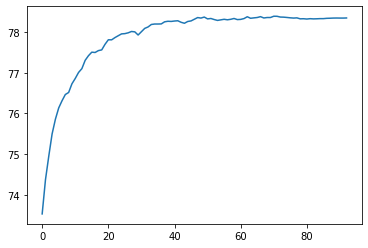

In [ ]:
plt.plot(corrs)

|实验项目|参数量|训练时间|准确率|训练参数|
|:---|:---:|:---:|:---:|:---|
|promptBert| 110072832【100%】 | |78.202 |lr(1.5e-5),w_d(1e-6),bs(128),ep(3)|
|promptBert+lora|  294912/110367744【0.267%】|599min |77.01625 |lr(1.5e-5),w_d(1e-6),bs(128),ep(6),r(8),lora_alpha(16)|
|promptBert+lora|  589824/110662656【0.533%】|586min | 76.8775|lr(1.5e-5),w_d(1e-6),bs(128),ep(6),r(16),lora_alpha(16)|

################################### original ###################################
evaluation_strategy   = "steps",
eval_steps            = 250,
learning_rate         = 1.5e-5,
num_train_epochs      = 6.0,
weight_decay          = 1e-6,
per_device_train_batch_size = 128,
per_device_eval_batch_size  = 128,
save_steps            = 1000,

+--------+--------+--------+--------+--------+--------------+-----------------+--------+
| STS12  | STS13  | STS14  | STS15  | STS16  | STSBenchmark | SICKRelatedness |  Avg.  |
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
| 70.08  | 84.79  | 77.16  | 83.47  | 79.53  |    80.29     |      70.88      | 78.03  |
| 0.205  | 0.236  | 0.227  | 0.244  | 0.209  |    0.206     |      0.175      | 0.215  |
| -1.948 | -2.073 | -2.061 | -1.897 | -2.016 |    -2.035    |      -1.817     | -1.978 |
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
acc before pooler: 78.02875 
max acc  78.02875
{'acc before pooler:': 78.02875, 'epoch': 0.71}

################################### Test 0 ###################################
Without feature pool and contrast CLS embedding directly

eval_steps            = 50,
learning_rate         = 3e-6,
num_train_epochs      = 6.0,
weight_decay          = 1e-6,
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
| STS12  | STS13  | STS14  | STS15  | STS16  | STSBenchmark | SICKRelatedness |  Avg.  |
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
| 71.66  | 84.55  | 76.38  | 82.64  | 79.28  |    79.19     |      70.81      | 77.79  |
| 0.280  | 0.331  | 0.330  | 0.342  | 0.290  |    0.285     |      0.222      | 0.297  |
| -2.628 | -2.899 | -2.856 | -2.561 | -2.762 |    -2.738    |      -2.297     | -2.677 |
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
Spearman before pooler: 77.7875 
max spearman  77.7875
{'Spearman before pooler:': 77.7875, 'epoch': 1.29}

################################### Test 1 ###################################
eval_steps            = 50,
learning_rate         = 3e-6,
num_train_epochs      = 6.0,
weight_decay          = 1e-6,
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
| STS12  | STS13  | STS14  | STS15  | STS16  | STSBenchmark | SICKRelatedness |  Avg.  |
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
| 71.18  | 85.21  | 77.46  | 83.40  | 80.12  |    80.73     |      71.11      | 78.46  |
| 0.203  | 0.239  | 0.232  | 0.252  | 0.207  |    0.204     |      0.171      | 0.215  |
| -1.967 | -2.139 | -2.103 | -1.929 | -2.040 |    -2.050    |      -1.818     | -2.007 |
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
Spearman before pooler: 78.45875000000001 
max spearman  78.45875000000001
{'Spearman before pooler:': 78.45875000000001, 'epoch': 1.23}

################################### Test 2 ###################################

Without Text2Img Projector
eval_steps            = 50,
learning_rate         = 3e-6,
num_train_epochs      = 6.0,
weight_decay          = 1e-6,
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
| STS12  | STS13  | STS14  | STS15  | STS16  | STSBenchmark | SICKRelatedness |  Avg.  |
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
| 71.41  | 84.77  | 77.33  | 83.86  | 80.28  |    81.10     |      70.86      | 78.52  |
| 0.210  | 0.240  | 0.239  | 0.257  | 0.210  |    0.208     |      0.177      | 0.220  |
| -2.051 | -2.203 | -2.179 | -1.975 | -2.108 |    -2.121    |      -1.882     | -2.074 |
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
Spearman before pooler: 78.51625 
max spearman  78.51625
{'Spearman before pooler:': 78.51625, 'epoch': 1.09}


################################### Test 3 ###################################

Without Text2Img Projector and Add hard negative sample
eval_steps            = 50,
learning_rate         = 3e-6,
num_train_epochs      = 6.0,
weight_decay          = 1e-6,
n                     = 2,
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
| STS12  | STS13  | STS14  | STS15  | STS16  | STSBenchmark | SICKRelatedness |  Avg.  |
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
| 70.46  | 84.67  | 77.03  | 83.94  | 79.62  |    80.52     |      70.44      | 78.10  |
| 0.220  | 0.254  | 0.250  | 0.266  | 0.224  |    0.220     |      0.182      | 0.231  |
| -2.107 | -2.295 | -2.248 | -2.031 | -2.182 |    -2.186    |      -1.921     | -2.139 |
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
Spearman before pooler: 78.09750000000001 
max spearman  78.09750000000001
{'Spearman before pooler:': 78.09750000000001, 'epoch': 0.98}


Without Text2Img Projector and Add hard negative sample
eval_steps            = 50,
learning_rate         = 3e-6,
num_train_epochs      = 6.0,
weight_decay          = 1e-6,
n                     = 5,
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
| STS12  | STS13  | STS14  | STS15  | STS16  | STSBenchmark | SICKRelatedness |  Avg.  |
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
| 71.07  | 84.97  | 77.58  | 84.03  | 80.24  |    80.93     |      70.28      | 78.44  |
| 0.202  | 0.234  | 0.231  | 0.246  | 0.203  |    0.200     |      0.166      | 0.212  |
| -1.953 | -2.113 | -2.083 | -1.894 | -2.005 |    -2.027    |      -1.804     | -1.983 |
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
Spearman before pooler: 78.4425 
max spearman  78.4425
{'Spearman before pooler:': 78.4425, 'epoch': 1.63}

Without Text2Img Projector and Add hard negative sample
eval_steps            = 50,
learning_rate         = 3e-6,
num_train_epochs      = 6.0,
weight_decay          = 1e-6,
n                     = 10,
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
| STS12  | STS13  | STS14  | STS15  | STS16  | STSBenchmark | SICKRelatedness |  Avg.  |
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
| 71.58  | 84.64  | 77.10  | 83.93  | 79.86  |    80.73     |      69.57      | 78.20  |
| 0.213  | 0.241  | 0.243  | 0.256  | 0.217  |    0.215     |      0.176      | 0.223  |
| -2.058 | -2.205 | -2.177 | -1.992 | -2.117 |    -2.144    |      -1.902     | -2.085 |
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
Spearman before pooler: 78.20125000000002 
max spearman  78.20125000000002
{'Spearman before pooler:': 78.20125000000002, 'epoch': 1.61}


Without Text2Img Projector and Add hard negative sample
eval_steps            = 50,
learning_rate         = 3e-6,
num_train_epochs      = 6.0,
weight_decay          = 1e-6,
n                     = 15,
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
| STS12  | STS13  | STS14  | STS15  | STS16  | STSBenchmark | SICKRelatedness |  Avg.  |
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
| 71.32  | 85.06  | 77.25  | 83.51  | 79.75  |    80.65     |      70.77      | 78.33  |
| 0.208  | 0.236  | 0.238  | 0.256  | 0.214  |    0.209     |      0.175      | 0.219  |
| -2.008 | -2.158 | -2.142 | -1.957 | -2.098 |    -2.095    |      -1.840     | -2.043 |
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
Spearman before pooler: 78.33 
max spearman  78.33
{'Spearman before pooler:': 78.33, 'epoch': 1.23}


Without Text2Img Projector and Add hard negative sample
eval_steps            = 50,
learning_rate         = 3e-6,
num_train_epochs      = 6.0,
weight_decay          = 1e-6,
n                     = 20,
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
| STS12  | STS13  | STS14  | STS15  | STS16  | STSBenchmark | SICKRelatedness |  Avg.  |
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
| 71.54  | 84.72  | 77.08  | 84.01  | 79.91  |    80.86     |      69.82      | 78.28  |
| 0.213  | 0.247  | 0.243  | 0.256  | 0.216  |    0.212     |      0.179      | 0.224  |
| -2.062 | -2.222 | -2.188 | -1.991 | -2.112 |    -2.134    |      -1.895     | -2.086 |
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
Spearman before pooler: 78.2775 
max spearman  78.2875
{'Spearman before pooler:': 78.2775, 'epoch': 1.47}


Test4 只用text feature
eval_steps            = 50,
learning_rate         = 3e-6,
num_train_epochs      = 6.0,
weight_decay          = 1e-6,
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
| STS12  | STS13  | STS14  | STS15  | STS16  | STSBenchmark | SICKRelatedness |  Avg.  |
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
| 71.65  | 84.84  | 77.16  | 84.05  | 79.52  |    80.63     |      69.65      | 78.21  |
| 0.217  | 0.253  | 0.250  | 0.261  | 0.223  |    0.218     |      0.179      | 0.229  |
| -2.126 | -2.318 | -2.272 | -2.054 | -2.202 |    -2.207    |      -1.939     | -2.160 |
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
Spearman before pooler: 78.21375 
max spearman  78.21375
{'Spearman before pooler:': 78.21375, 'epoch': 1.43}

Test5 原句token过一下预训练的多模态文本BERT，然后拿到对应位置的 MASK embedding 和 CLS embedding， 然后直接对比
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
| STS12  | STS13  | STS14  | STS15  | STS16  | STSBenchmark | SICKRelatedness |  Avg.  |
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
| 65.07  | 78.64  | 69.53  | 78.11  | 73.03  |    75.36     |      69.05      | 72.68  |
| 0.160  | 0.193  | 0.185  | 0.191  | 0.159  |    0.152     |      0.122      | 0.166  |
| -1.717 | -1.846 | -1.788 | -1.569 | -1.678 |    -1.713    |      -1.478     | -1.684 |
+--------+--------+--------+--------+--------+--------------+-----------------+--------+
Spearman before pooler: 72.68375 
max spearman  72.68375
{'Spearman before pooler:': 72.68375, 'epoch': 0.02}

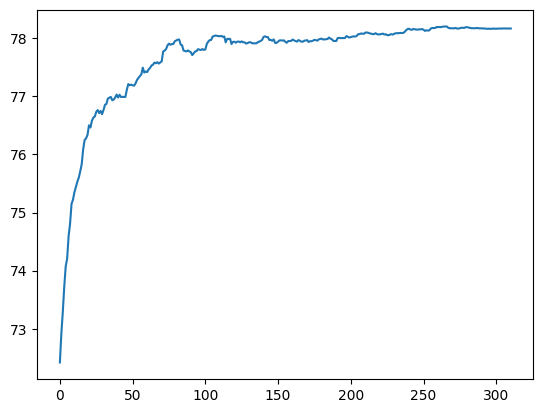

In [ ]:
plt.plot(corrs)

In [ ]:
# Test Best model on downstream tasks
# model_name = 'bert-base-uncased'
model_name = 'bert-large-uncased'

checkpoint_path = output_path+'/best-model/'
# checkpoint_path = 'RESULTS/bert_base_flickr30k_512_clip-vit-base-patch32_test2/best-model-78.58/'

# visual_ft_path = 'data/flickr30k/flickr30k_trainset_img_features_768x768_p32.pt'
visual_ft_path = 'data/flickr30k/flickr30k_trainset_text_features_512_clip-vit-base-patch32.pt'
# visual_ft_path = 'data/COCO2017/COCO2017_trainset_img_features_512x512_p32.pt'

tokenizer1 = BertTokenizer.from_pretrained(model_name, cache_dir='./cache')

# ############### BERT ############################
config = BertConfig.from_pretrained(checkpoint_path+'config.json', cache_dir='./cache')
visual_pool = torch.load(visual_ft_path).cuda()
model1 = VisualGuidedPromptModel(config=config, visual_pool=visual_pool)
model1.temp_denosie = False

model1.load_state_dict(torch.load(checkpoint_path+'pytorch_model.bin'))

# 测试时不启用 BatchNormalization 和 Dropout
model1.eval().cuda()

print_trainable_parameters(model1)

evalTransferModel(model1,tokenizer1, pooler = 'cls_before_pooler')

trainable params: 336191488 || all params: 336191488 || trainable%: 100.0
+-------+-------+-------+-------+-------+-------+-------+-------+
|   MR  |   CR  |  SUBJ |  MPQA |  SST2 |  TREC |  MRPC |  Avg. |
+-------+-------+-------+-------+-------+-------+-------+-------+
| 86.45 | 91.01 | 96.19 | 89.17 | 90.37 | 86.59 | 74.14 | 87.70 |
+-------+-------+-------+-------+-------+-------+-------+-------+


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('float64'), dtype('<U5')) -> None

In [ ]:
# Test Best model on downstream tasks
model_name = 'roberta-large'

# checkpoint_path = 'RESULTS/roberta-large_flickr_512_clip-vit-base-patch32_test2/best-model-80.74/'
checkpoint_path = 'RESULTS/roberta-large_coco_512_clip-vit-base-patch32_test2/best-model-80.99/'

# visual_ft_path = 'data/COCO2017/COCO2017_trainset_img_features_clip-vit-base-patch32.pt'
visual_ft_path = 'data/COCO2017/COCO2017_trainset_img_features_512x512_p32.pt'
# visual_ft_path = 'data/COCO2017/COCO2017_trainset_img_features_768x768_p32.pt'

tokenizer = RobertaTokenizer.from_pretrained(model_name, cache_dir='./cache')

############### Roberta ############################
config = RobertaConfig().from_pretrained(checkpoint_path)

model = VisualGuidedPromptModel_roberta(config=config, visual_pool=visual_ft_path)
model.roberta_model = model.roberta_model.from_pretrained(model_name, cache_dir='./cache')

model.load_state_dict(torch.load(checkpoint_path+'pytorch_model.bin'))

# 测试时不启用 BatchNormalization 和 Dropout
model.eval().cuda()

print_trainable_parameters(model)

evalTransferModel(model,tokenizer, pooler = 'cls_before_pooler')

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


trainable params: 357458944 || all params: 357458944 || trainable%: 100.0
+-------+------+-------+------+-------+-------+-------+-------+
|   MR  |  CR  |  SUBJ | MPQA |  SST2 |  TREC |  MRPC |  Avg. |
+-------+------+-------+------+-------+-------+-------+-------+
| 84.14 | 89.0 | 94.28 | 88.7 | 86.24 | 81.53 | 73.11 | 85.29 |
+-------+------+-------+------+-------+-------+-------+-------+


[84.14, 89.0, 94.28, 88.7, 86.24, 81.53, 73.11, '85.29']

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.sans-serif'] = 'Times New Roman'
import seaborn as sns
import pandas as pd
import numpy as np
from pylab import xticks,yticks
from tqdm import tqdm

In [ ]:
### [Recommended] just load the pre-processed file ###
# wiki_for_sts = "data/wiki_promptRobertabase_t2_64_with_mask"
wiki_for_sts = "data/wiki_promptBertbase_t2_64_with_mask/"
train_dataset = load_from_disk(wiki_for_sts)

In [ ]:
train_dataset

NameError: name 'train_dataset' is not defined

In [ ]:
train_iter = iter(train_dataset)

sim_origin = []
for i in tqdm(range(7500)):
    text_pos = next(train_iter)
    text_neg = next(train_iter)
    
    # get cls of positive samples
    cls_pos = model(
        input_ids = text_pos['input_ids'][0].cuda(),
        attention_mask = text_pos['attention_mask'][0].cuda(),
        token_type_ids = text_pos['token_type_ids'][0].cuda(),
    ).last_hidden_state[:,0]
    
    # get cls of origin negative samples
    cls_neg_origin = model(
        input_ids = text_neg['input_ids'][0].cuda(),
        attention_mask = text_neg['attention_mask'][0].cuda(),
        token_type_ids = text_neg['token_type_ids'][0].cuda(),
    ).last_hidden_state[:,0]
    
    sim_origin += torch.nn.functional.cosine_similarity(cls_pos,cls_neg_origin).detach().cpu().tolist()

num,steps = np.histogram([abs(i) for i in sim_origin],bins=100,range=(0,1))
bins_data = np.concatenate((num.reshape(-1,1),steps[:-1].reshape(-1,1)),axis=1)
bins_data = pd.DataFrame(bins_data,columns=["number","steps"])

In [ ]:
plt.figure(dpi=1500,figsize=(10,6.18))
plt.title("Cosine Similarity of BERT-base on Random WiKiData",fontsize=24)
sns.lineplot(x="steps",y="number",data=bins_data)
plt.tick_params(labelsize=18)

plt.xlabel('Cosine Similarity',fontsize=24)
plt.ylabel('Number of Sentence',fontsize=24)